### Data

In [1]:
plt.style.use('bmh')

df_players = pd.read_pickle('data/df_players.pkl')
print(df_players.shape)
df_players[:3]

(1614, 16)


,player_id,season_max,season_len,birth_year,start_year,draft_number,display_name,height_cm,weight_kg,bmi_calc,team_abbr,position_group,position,Position,Category,fold
0,00-0007091,2016,1,"1,975.00",NaN,0,Matt Hasselbeck,193.04,106.59,28.60,IND,QB,QB,Quarterback,Offense,3
1,00-0010346,2016,1,"1,976.00",NaN,0,Peyton Manning,195.58,104.33,27.27,DEN,QB,QB,Quarterback,Offense,1
2,00-0019596,2023,8,"1,977.00","2,000.00",1,Tom Brady,193.04,102.06,27.39,TB,QB,QB,Quarterback,Offense,2


In [2]:
df = pd.read_pickle('data/df_season.pkl')
print(df.shape)
df[:3]

(4655, 96)


,player_id,season,team,bmi,fantasy_points_per_game,fantasy_points_ppr,games,receiving_receptions,receiving_targets,passing_tds,passing_interceptions,passing_epa,receiving_epa,rushing_carries,rushing_epa,rushing_tds,receiving_tds,receiving_target_team_share,passing_yards,passing_air_yards,passing_yards_after_catch,rushing_yards,receiving_yards,receiving_air_yards,receiving_yards_after_catch,passing_air_yards_share,passing_attempts,passing_completions,passing_pacr,_other_dakota,passing_fumbles,rushing_fumbles,receiving_fumbles,receiving_racr,receiving_wopr_x,_other_yac_sh,_other_ry_sh,_other_rtd_sh,_other_rfd_sh,_other_dom,_other_w8dom,_other_yptmpa,_other_ppr_sh,passing_completions_per_game,passing_attempts_per_game,passing_yards_per_game,passing_tds_per_game,passing_interceptions_per_game,passing_air_yards_per_game,passing_yards_after_catch_per_game,rushing_attempts_per_game,rushing_yards_per_game,rushing_tds_per_game,receiving_receptions_per_game,receiving_targets_per_game,receiving_yards_per_game,receiving_tds_per_game,receiving_air_yards_per_game,receiving_yards_after_catch_per_game,passing_points,passing_fumbles_per_game,passing_points_per_game,passing_complete_share,passing_interceptions_share,passing_fumbles_share,passing_points_share,passing_yards_after_catch_share,receiving_points,receiving_fumbles_per_game,receiving_points_per_game,receiving_receptions_share,receiving_fumbles_share,receiving_points_share,receiving_air_yards_share,receiving_yards_after_catch_share,rushing_points,rushing_carries_per_game,rushing_fumbles_per_game,rushing_points_per_game,rushing_fumbles_share,rushing_points_share,calc_points,season_max,season_len,static_birth_year,static_start_year,static_draft_number,display_name,static_height_cm,static_weight_kg,static_bmi_calc,position_group,position,Position,Category,fold
0,00-0007091,2016,IND,NaN,11.39,91.10,8,0,0,9,5.00,-0.11,0.00,16,-5.87,0,0,0.00,"1,690.00","1,900.00",779.00,15.00,0.00,0.00,0.00,1.12,256,156,7.42,0.53,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,19.50,32.00,211.25,1.12,0.62,237.50,97.38,2.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,93.60,0.38,11.70,0.61,0.02,0.01,1.03,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,2.00,0.00,0.19,0.00,0.02,95.10,2016,1,"1,975.00",NaN,0,Matt Hasselbeck,193.04,106.59,28.60,QB,QB,Quarterback,Offense,3
1,00-0010346,2016,DEN,NaN,9.14,91.36,10,0,0,9,17.00,-31.96,0.00,6,-3.62,0,0,0.00,"2,249.00","3,112.00",967.00,-6.00,0.00,0.00,0.00,1.38,331,198,7.33,0.52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,19.80,33.10,224.90,0.90,1.70,311.20,96.70,0.60,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.96,0.10,9.20,0.60,0.05,0.00,1.01,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,0.60,0.00,-0.06,0.00,-0.01,91.36,2016,1,"1,976.00",NaN,0,Peyton Manning,195.58,104.33,27.27,QB,QB,Quarterback,Offense,1
2,00-0019596,2016,NE,0.04,21.51,344.70,16,1,1,36,7.00,127.25,3.13,34,6.85,3,0,0.02,"4,770.00","4,915.00","2,414.00",53.00,36.00,7.00,29.00,1.03,624,402,17.19,1.99,5,1.00,0.00,5.14,0.04,0.01,0.01,0.00,0.00,0.00,0.01,0.06,0.21,25.12,39.00,298.12,2.25,0.44,307.19,150.88,2.12,3.31,0.19,0.06,0.06,2.25,0.00,0.44,1.81,320.80,0.31,20.05,0.64,0.01,0.01,0.93,0.51,4.60,0.00,0.29,1.00,0.00,0.01,0.19,0.81,21.30,2.12,0.06,1.33,0.03,0.06,346.70,2023,8,"1,977.00","2,000.00",1,Tom Brady,193.04,102.06,27.39,QB,QB,Quarterback,Offense,2


### Teams scores

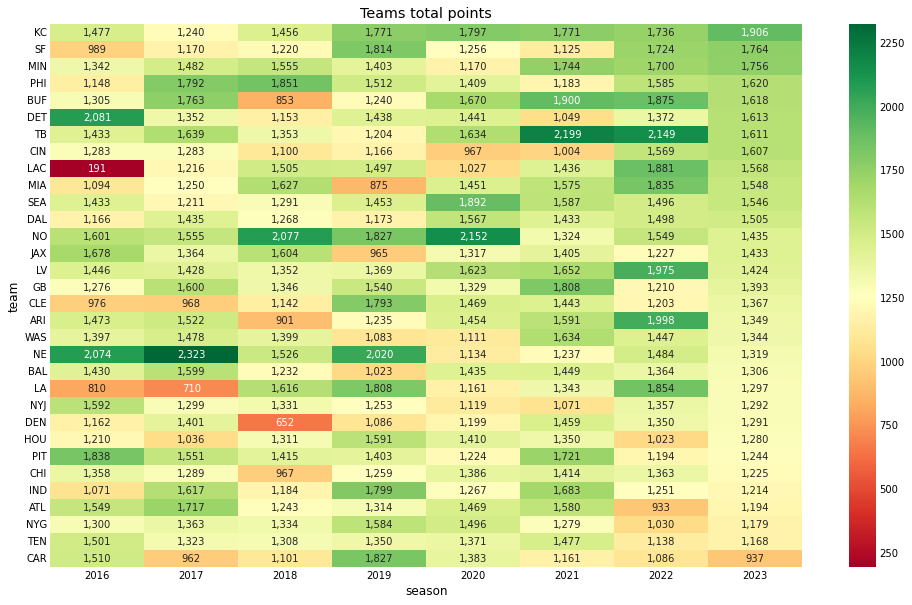

In [3]:
# team scores by position
df_corr = df.groupby(['team','season']).fantasy_points_ppr.sum().unstack()
df_corr = df_corr[~df_corr[2023].isnull()].sort_values(2023, ascending = False)
_, ax = plt.subplots(figsize = (15,10))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws={"size": 10})
_ = ax.set_title('Teams total points')

### Teams clustering

(33, 5)


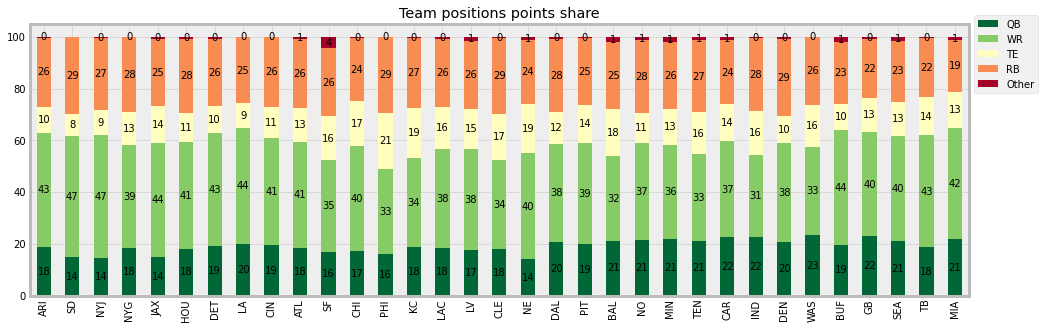


Average points share per cluster:


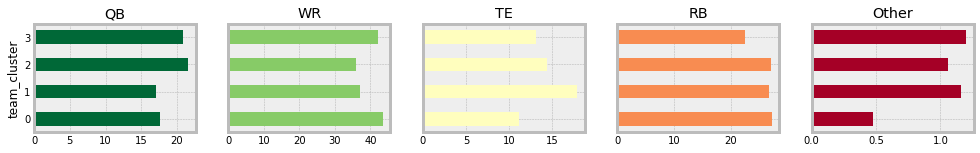

In [4]:
###############
# Clustering of teams by the position scores share

# 1) create shares data
filt = df.season <= 2022
df_teams = df[filt].groupby(['team','position']).fantasy_points_ppr.sum().unstack()
list_pos = ['QB', 'WR', 'TE', 'RB']
df_teams['Other'] = df_teams.sum(axis = 1) - df_teams[list_pos].sum(axis = 1)
df_teams = df_teams[list_pos+['Other']]
df_teams = 100*df_teams.apply(lambda x: x/sum(x), axis = 1)
df_teams = df_teams[~df_teams.QB.isnull()]
print(df_teams.shape)

x = df_teams.copy()
del x['Other']
for f in x.columns:
    x[f] = (x[f] - x[f].mean())/x[f].std()

# 2) kmeans clustering
from sklearn.cluster import KMeans
np.random.seed(2017)
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
df_teams['team_cluster'] = kmeans.labels_
df_teams = df_teams.sort_values('team_cluster')

p = df_teams.iloc[:,:-1].plot(figsize = (15,5), kind = 'bar', stacked = True, legend = True, title = 'Team positions points share', cmap = 'RdYlGn_r', xlabel = '')
p.legend(bbox_to_anchor=(1., 1.05))
for c in p.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in c]    
    p.bar_label(c, labels=labels, label_type='center')
plt.show()

# Clusters description
df_corr = df_teams.groupby('team_cluster').mean()
print('')
print('Average points share per cluster:')
_ = df_corr.plot(kind = 'barh', subplots = True, layout = (1,5), sharey = True, sharex = False, figsize = (15,2), legend = False, cmap = 'RdYlGn_r')

In [5]:
# where is the last team
df_teams.reset_index().groupby('team_cluster').last()

position,team,QB,WR,TE,RB,Other
team_cluster,,,,,,
0,ATL,18.36,41.10,13.09,26.44,1.01
1,NE,14.07,40.89,19.17,24.79,1.08
2,WAS,23.50,33.95,16.21,26.27,0.08
3,MIA,21.82,42.97,13.90,19.96,1.35


### Players filtering

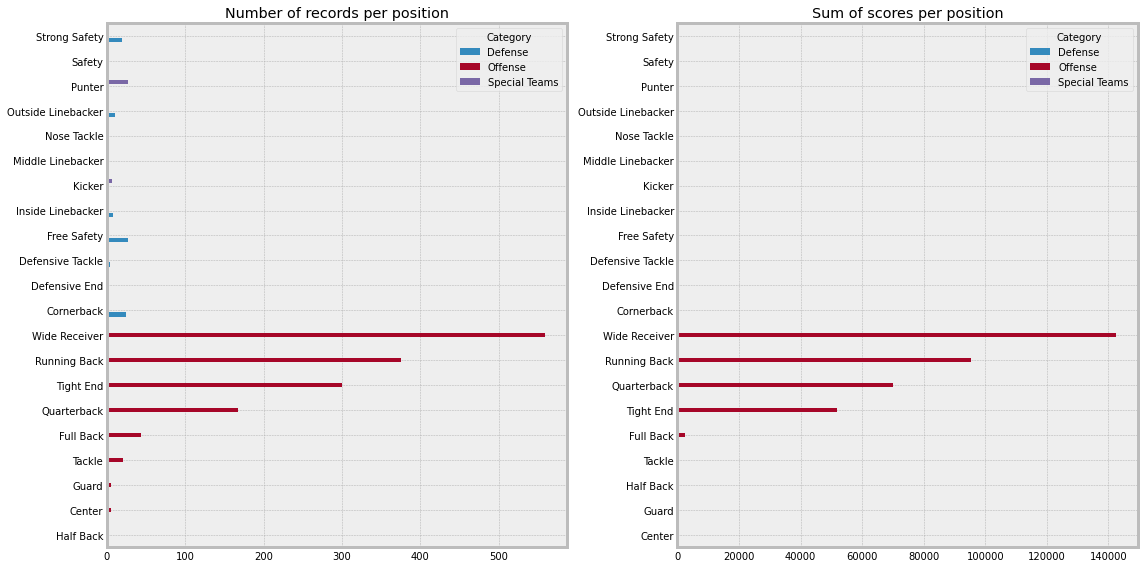

In [6]:
# positions exploration
_, ax = plt.subplots(1,2,figsize = (16,8))

_ = df_players.groupby(['Category','Position']).size().unstack().T.sort_values('Offense').plot(ax = ax[0], kind = 'barh', title = 'Number of records per position', ylabel = '')

dict1 = df.groupby('player_id').fantasy_points_ppr.sum().to_dict()
df_players['score_sum'] = df_players['player_id'].map(dict1)
_ = df_players.groupby(['Category','Position']).score_sum.sum().unstack().T.sort_values('Offense').plot(ax = ax[1], kind = 'barh', title = 'Sum of scores per position', ylabel = '')
plt.tight_layout()

In [7]:
# We save last value predictions for the FullBack position
df_add1 = df_players[df_players.position == 'FB'][['player_id','display_name']] 
df_add2 = df[df.season == 2023][['player_id','fantasy_points_ppr']]
df_add = df_add1.merge(df_add2)
del df_add['player_id']
df_add.columns = ['Player Name', 'Projected fantasy points scored PPR for 2023']
df_add.to_csv('data/output_add1.csv', index = False)

In [8]:
# For modeling wee took these positions only
list_pos = ['QB', 'WR', 'TE', 'RB']#, 'FB']
filt0 = df_players.position.isin(list_pos)
print(df_players.shape)
df_players = df_players[filt0]
print(df_players.shape)

(1614, 17)
(1401, 17)


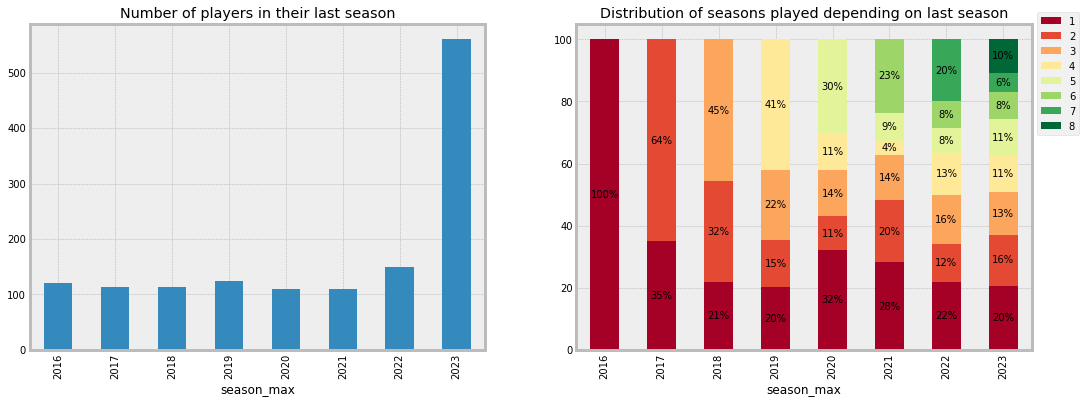

In [9]:
# Number of seasons exploration
# plot 1
df_st = df_players.groupby(['season_max','season_len']).size().unstack().fillna(0).astype(int)
# display(df_st)

_, ax = plt.subplots(1,2,figsize = (16,6))
_ = df_st.T.sum().plot(ax = ax[0], kind = 'bar', title = 'Number of players in their last season')

# shares plotting
df_st = 100*df_st.apply(lambda x: x/sum(x), axis = 1)
p = df_st.plot(ax = ax[1], kind = 'bar', stacked = True, legend = True, title = 'Distribution of seasons played depending on last season', cmap = 'RdYlGn')
p.legend(bbox_to_anchor=(1., 1.05))
for c in p.containers:
    labels = [f'{int(v.get_height())}%' if v.get_height() > 0 else '' for v in c]    
    p.bar_label(c, labels=labels, label_type='center')

In [10]:
# filters for training: 
# - took only active players with at least 2 seasons
# - took only players with 2023 as their last season
filt1 = df_players.season_len > 1
filt2 = df_players.season_max == 2023

print(df_players.shape)
print(df_players[filt1&filt2].shape)

(1401, 17)
(444, 17)


In [11]:
df_players[filt1&filt2].isnull().sum().sum() # in the training 

0

In [12]:
# now apply only one:
df_players = df_players[filt2]
print(df_players.shape)

(560, 17)


In [13]:
# merging
print(df.player_id.nunique(), df.shape)
df = df.merge(df_players[['player_id']])
print(df.player_id.nunique(), df.shape)

1614 (4655, 96)
560 (2139, 96)


In [14]:
a = df.isnull().sum()
a[a>0]

bmi                  573
_other_rtd_sh         31
_other_dom            31
_other_w8dom          31
static_birth_year    106
static_start_year    116
dtype: int64

### Players scores

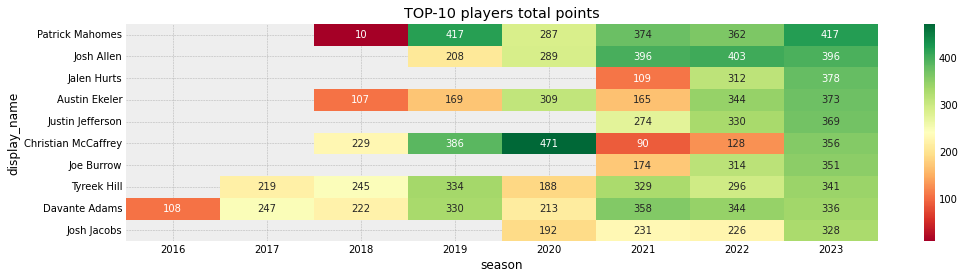

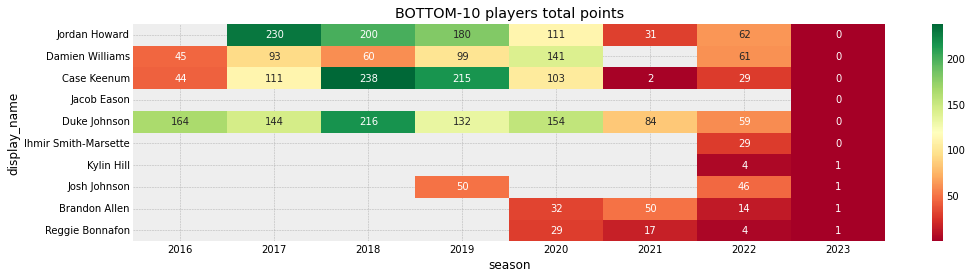

In [15]:
# team scores by position
N = 10
df_corr = df.groupby(['display_name','season']).fantasy_points_ppr.sum().unstack()
df_corr = df_corr[~df_corr[2023].isnull()].sort_values(2023, ascending = False)[:N]
_, ax = plt.subplots(figsize = (15,4))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws={"size": 10})
_ = ax.set_title(f'TOP-{N} players total points')

df_corr = df.groupby(['display_name','season']).fantasy_points_ppr.sum().unstack()
df_corr = df_corr[~df_corr[2023].isnull()].sort_values(2023, ascending = True)[:N]
_, ax = plt.subplots(figsize = (15,4))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws={"size": 10})
_ = ax.set_title(f'BOTTOM-{N} players total points')

### Player position statistics

In [16]:
# add last year points to players table
feats_points = [
    'passing_points',
    'receiving_points',
    'rushing_points',
    'fantasy_points_ppr',
]
df1 = df.groupby('player_id')[feats_points].mean().reset_index()
df_players = df_players.merge(df1)

feats_static = [
 'height_cm',
 'weight_kg',
 'bmi_calc',
 'birth_year',
]
# position profiles
feats = feats_static + feats_points
df0 = df_players.groupby('Position').mean()[feats]
display(df0.style.background_gradient(cmap='RdYlGn').set_precision(1))

,height_cm,weight_kg,bmi_calc,birth_year,passing_points,receiving_points,rushing_points,fantasy_points_ppr
Position,,,,,,,,
Quarterback,189.7,99.8,27.7,1993.1,102.3,0.6,19.3,123.4
Running Back,180.1,96.8,29.8,1995.9,0.0,36.0,53.6,90.7
Tight End,194.6,112.9,29.8,1995.0,0.0,54.1,0.3,54.8
Wide Receiver,184.7,90.2,26.4,1995.5,0.1,84.9,2.1,87.9


### Players total points by season (cohort analysis)

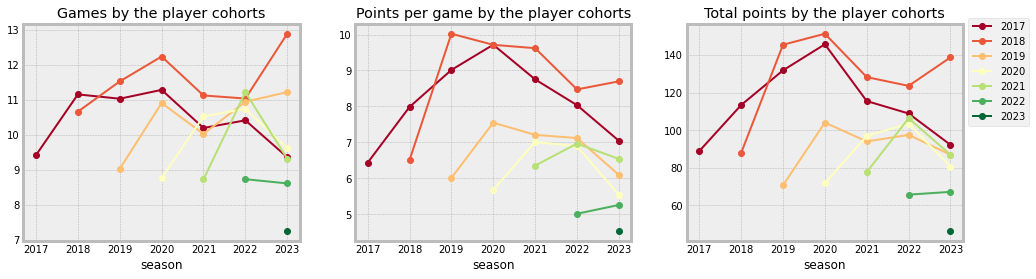

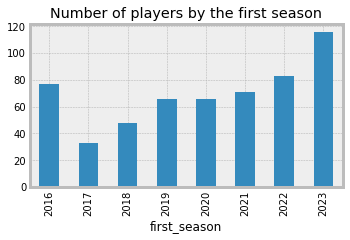

In [17]:
# first season
dict_repl = df.groupby('player_id').season.min().to_dict()
df['first_season'] = df.player_id.map(dict_repl)

_, ax = plt.subplots(1,3, figsize = (15,4))
_ = df.groupby(['season', 'first_season'])['games'].mean().unstack().iloc[:,1:].plot(ax = ax[0], style = 'o-', cmap = 'RdYlGn', title = 'Games by the player cohorts', legend = False)
_ = df.groupby(['season', 'first_season'])['fantasy_points_per_game'].mean().unstack().iloc[:,1:].plot(ax = ax[1], style = 'o-', cmap = 'RdYlGn', title = 'Points per game by the player cohorts', legend = False)
_ = df.groupby(['season', 'first_season'])['fantasy_points_ppr'].mean().unstack().iloc[:,1:].plot(ax = ax[2], style = 'o-', cmap = 'RdYlGn', title = 'Total points by the player cohorts')
_ = _.legend(bbox_to_anchor=(1., 1.05))

plt.show()
_ = df.groupby('first_season').player_id.nunique().plot(figsize = (5,3), kind = 'bar', title = 'Number of players by the first season')

### Players clustering

In [18]:
###############
# Clustering of players by the points type share

# 1) create players scores data
filt = df.season <= 2023
dict_points = {
    'passing_tds': 4,
    'passing_yards': 0.04,
    'passing_interceptions': -2,
    'receiving_tds': 6,
    'receiving_yards': 0.1,
    'receiving_receptions': 1,
    'receiving_fumbles': -2,
    'rushing_tds': 6,
    'rushing_yards': 0.1,
    'rushing_fumbles': -2,
}
df_pl = df[filt].groupby('player_id')[list(dict_points)].sum()#.unstack()
for f,v in dict_points.items():
    df_pl[f] = df_pl[f] * v
df_pl.fillna(0, inplace = True)

# players who haven't got minimum points - they could have anomaly low or high shares 
# player_scores = df_pl.sum(axis = 1)
# player_scores_low = player_scores[player_scores < 10]
# print('players without clusters:', len(player_scores_low))
# df_pl = df_pl[~df_pl.index.isin(player_scores_low.index)]
# print('players with clusters:', len(df_pl))

# fumbles are redundant information
df_pl = 100*df_pl.apply(lambda x: x/sum(x), axis = 1)
for f in ['passing_interceptions','receiving_fumbles','rushing_fumbles']:
    del df_pl[f]
# for f in df_pl.columns:
#     df_pl[f] = df_pl[f].clip(0,100)
x = df_pl.copy()
for f in x.columns:
    x[f] = x[f].clip(0,100)
    x[f] = (x[f] - x[f].mean())/x[f].std()

# 2) Kmeans clustering
from sklearn.cluster import KMeans
np.random.seed(2022)
kmeans = KMeans(n_clusters=6)
kmeans.fit(x)

# 3) add cluster and position
df_pl['player_cluster'] = kmeans.labels_
df_pl = df_pl.sort_values('player_cluster')
players_pos = df_players.set_index('player_id')['position'].to_dict()
df_pl['player_pos'] = df_pl.reset_index()['player_id'].map(players_pos).values

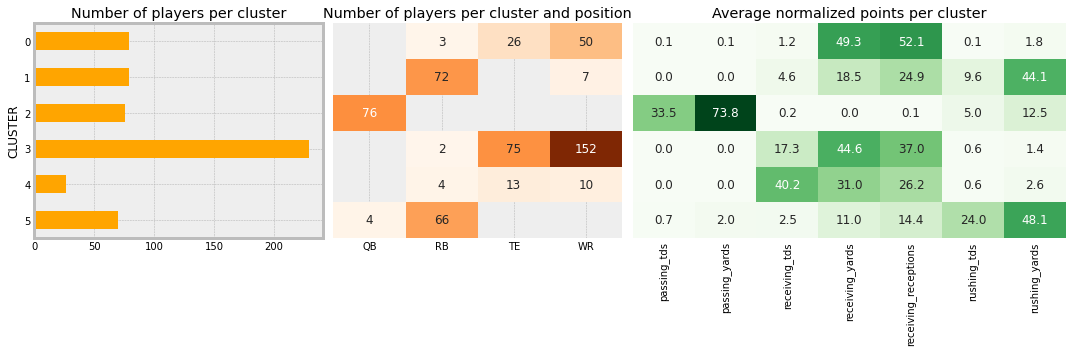

In [19]:
# clusters description
# df_cl = x.groupby('cluster').mean().iloc[:,:-1]
# df_cl = df_cl.sort_index(ascending = False)

_, ax = plt.subplots(1,3, figsize = (15,5), width_ratios=[1, 1, 1.5])

df_cl = df_pl.player_cluster.value_counts().sort_index(ascending = False)
_ = df_cl.plot(ax = ax[0], kind = 'barh', color = 'orange', title = 'Number of players per cluster', ylabel = 'CLUSTER')

df_cl = df_pl.groupby(['player_cluster', 'player_pos']).size().unstack()
_ = sns.heatmap(df_cl, ax = ax[1], cmap = 'Oranges', annot = True, fmt = '.0f', annot_kws={"size": 12}, cbar = False, yticklabels=False)
_ = ax[1].set_title('Number of players per cluster and position')
_ = ax[1].set_xlabel('')
_ = ax[1].set_ylabel('')

df_cl = df_pl.groupby('player_cluster').mean()
_ = sns.heatmap(df_cl, ax = ax[2], cmap = 'Greens', annot = True, fmt = '.1f', annot_kws={"size": 12}, cbar = False, yticklabels=False)
_ = ax[2].set_title('Average normalized points per cluster')
_ = ax[2].set_xlabel('')
_ = ax[2].set_ylabel('')

plt.tight_layout()

### Save data for modeling

In [20]:
# merge with clusters data
df_teams1 = df_teams.reset_index()[['team','team_cluster']]
df = df.merge(df_teams1, how = 'left')

df_pl1 = df_pl.reset_index()[['player_id','player_cluster']]
df = df.merge(df_pl1, how = 'left')

In [21]:
# features groups
feats_player1 = [
 'player_id',
 'display_name',
 'season',
 'fold',
 'season_len',
 'season_max',
]

feats_target = [
 'games',
 'fantasy_points_per_game',
 'fantasy_points_ppr',
]

feats_static = [
 # 'static_birth_year',
 # 'static_start_year',
 # 'static_draft_number',
 'static_height_cm',
 'static_weight_kg',
 'static_bmi_calc',
]

feats_cat = [
 'team',
 'position',
 'team_cluster',
 'player_cluster'
]

In [22]:
# features could be used for training
feats_train = (
    feats_player1
    + feats_target
    + feats_static
    + feats_cat
)

df[feats_train].to_pickle('data/df_model.pkl')
print(df[feats_train].shape)
df[feats_train][:5]

(2139, 16)


,player_id,display_name,season,fold,season_len,season_max,games,fantasy_points_per_game,fantasy_points_ppr,static_height_cm,static_weight_kg,static_bmi_calc,team,position,team_cluster,player_cluster
0,00-0019596,Tom Brady,2016,2,8,2023,16,21.51,344.70,193.04,102.06,27.39,NE,QB,1,2
1,00-0019596,Tom Brady,2017,2,8,2023,12,21.55,258.56,193.04,102.06,27.39,NE,QB,1,2
2,00-0019596,Tom Brady,2018,2,8,2023,16,18.49,295.88,193.04,102.06,27.39,NE,QB,1,2
3,00-0019596,Tom Brady,2019,2,8,2023,16,17.55,281.30,193.04,102.06,27.39,NE,QB,1,2
4,00-0019596,Tom Brady,2020,2,8,2023,16,16.48,263.68,193.04,102.06,27.39,TB,QB,3,2
